Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/50
360/360 [==============================] - 104s 285ms/step - loss: 1.8142 - accuracy: 0.2465 - val_loss: 1.7486 - val_accuracy: 0.2818
Epoch 2/50
360/360 [==============================] - 97s 270ms/step - loss: 1.7433 - accuracy: 0.2852 - val_loss: 1.6783 - val_accuracy: 0.3403
Epoch 3/50
360/360 [==============================] - 105s 293ms/step - loss: 1.6857 - accuracy: 0.3253 - val_loss: 1.5303 - val_accuracy: 0.4001
Epoch 4/50
360/360 [==============================] - 98s 272ms/step - loss: 1.6007 - accuracy: 0.3696 - val_loss: 1.4422 - val_accuracy: 0.4482
Epoch 5/50
360/360 [==============================] - 95s 263ms/step - loss: 1.5338 - accuracy: 0.4023 - val_loss: 1.4178 - val_accuracy: 0.4643
Epoch 6/50
360/360 [==============================] - 98s 272ms/step - loss: 1.4868 - accuracy: 0.4256 - val_loss: 1.3318 - val_accuracy: 0.4913

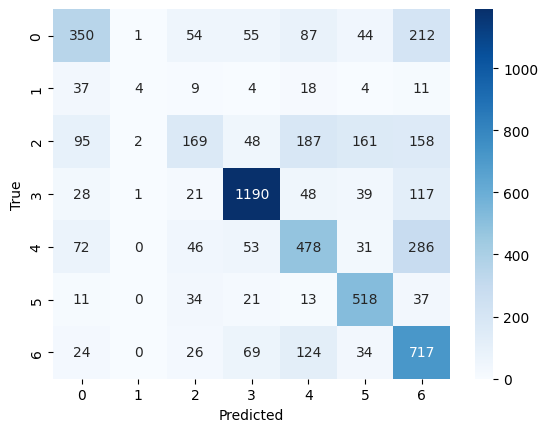

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Path to the directory containing images
data_path = '/content/drive/My Drive/Colab Notebooks/Nature inspired/Group_Mini/Emotion Detection/train'

# Data Exploration and Preprocessing
images = []
labels = []

# Get the list of categories (subdirectories) in the data_path
categories = os.listdir(data_path)

# Loop through each category
for category in categories:
    category_path = os.path.join(data_path, category)
    label = categories.index(category)
    for img_filename in os.listdir(category_path):
        try:
            img = cv2.imread(os.path.join(category_path, img_filename), cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (48, 48))
            img = img / 255.0
            images.append(img)
            labels.append(label)
        except Exception as e:
            print("Error loading image:", e)

# Convert the lists to NumPy arrays
images = np.array(images)
labels = np.array(labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, stratify=labels, random_state=42)

# Reshape images to include channel dimension
X_train = X_train.reshape(-1, 48, 48, 1)
X_test = X_test.reshape(-1, 48, 48, 1)

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)

# Model Architecture cnn
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(categories), activation='softmax')
])

# Compilation
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Training
history = model.fit(datagen.flow(X_train, y_train, batch_size=64), epochs=50, validation_data=(X_test, y_test), verbose=1)

# Evaluation
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification Report
print(classification_report(y_test, y_pred_classes))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [2]:
# Save the trained model
model.save('new_emotion_detection_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [3]:
# Load the saved Keras model
model = tf.keras.models.load_model('new_emotion_detection_model.h5')

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the converted model to a file
with open('new_emotion_detection_model.tflite', 'wb') as f:
    f.write(tflite_model)
